## Predictor variable selection ## 

#### forward selection (Eforymson 1966; Draper and Smith 1966) ####

Iteratively build up a model by adding one predictor variable at a time, starting one with no predictors.

Run the following 3 steps until you run out of predictors:
1. For each unused predictor, add it to the model to form a candidate model.
2. Tune all of the candidate models.
3. Update the model to be the candidate model with the highest cross-validation accuracy.

Select the model that provides the best trade-off between accuracy and simplicity.

### set-up ###

In [3]:
# loading packages
library(repr)
library(tidyverse)
library(tidymodels)
# library(themis)
set.seed(31)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [4]:
# loading data
stroke <- read_csv("data/stroke-data.csv")
colnames(stroke)

Parsed with column specification:
cols(
  id = col_double(),
  gender = col_character(),
  age = col_double(),
  hypertension = col_double(),
  heart_disease = col_double(),
  ever_married = col_character(),
  work_type = col_character(),
  Residence_type = col_character(),
  avg_glucose_level = col_double(),
  bmi = col_character(),
  smoking_status = col_character(),
  stroke = col_double()
)



[1] "id"                "gender"            "age"              
 [4] "hypertension"      "heart_disease"     "ever_married"     
 [7] "work_type"         "Residence_type"    "avg_glucose_level"
[10] "bmi"               "smoking_status"    "stroke"

In [5]:
# cleaning and wrangling
# stroke_clean <- stroke %>%
#     select(gender, age, hypertension, heart_disease, avg_glucose_level, bmi, smoking_status, stroke) %>%
#     mutate(gender = as_factor(gender), 
#            bmi = as.numeric(bmi),
#            smoking_status = as_factor(smoking_status),
#            stroke = as_factor(stroke)) %>%
#     filter(gender != "Other") #Other was removed as there was only one occurrence in the dataset

# prep and bake data with upsampling, then use it with everything
# gonna overfit data, data leakage
stroke_clean <- stroke %>%
    select(age, hypertension, heart_disease, avg_glucose_level, bmi, stroke) %>%
    mutate(stroke = as_factor(stroke),
           bmi = as.numeric(bmi)) 

Warning message:
“Problem with `mutate()` input `bmi`.
ℹ NAs introduced by coercion
ℹ Input `bmi` is `as.numeric(bmi)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


In [6]:
head(stroke_clean)

age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
67,0,1,228.69,36.6,1
61,0,0,202.21,NA,1
80,0,1,105.92,32.5,1
49,0,0,171.23,34.4,1
79,1,0,174.12,24.0,1
81,0,0,186.21,29.0,1


#### Split data

In [7]:
stroke_split <- initial_split(stroke_clean, prop = 0.75, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)

### Downsampling

In [8]:
ds_recipe <- recipe(stroke ~ ., data = stroke_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    step_downsample(stroke, under_ratio = 1, skip = FALSE) %>%
    prep()
dsampled_stroke <- bake(ds_recipe, stroke_train)

Warning message:
“`step_downsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_downsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [9]:
up_recipe <- recipe(stroke ~ ., data = stroke_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    step_upsample(stroke, over_ratio = 1, skip = FALSE) %>%
    prep()
upsampled_stroke <- bake(up_recipe, stroke_train)

# upsampled_stroke %>%
#   group_by(stroke) %>%
#   summarize(n = n())

# head(upsampled_stroke)
# tail(upsampled_stroke)

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


### Forward Selection

In [8]:
# DOWNSAMPLE here!!!

In [18]:
stroke_subset <- dsampled_stroke %>%
    filter(!is.na(bmi))
names <- colnames(dsampled_stroke %>% select(-stroke)) %>% sort()
names

[1] "age"               "avg_glucose_level" "bmi"              
[4] "heart_disease"     "hypertension"

In [19]:
example_formula <- paste("stroke", "~", paste(names, collapse="+"))
example_formula

[1] "stroke ~ age+avg_glucose_level+bmi+heart_disease+hypertension"

In [20]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>


In [21]:
# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
stroke_vfold <- vfold_cv(stroke_subset, v = 5, strata = stroke)

gridvals <- tibble(neighbors = seq(from = 1, to = 20, by = 2))

In [22]:
# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

In [23]:
set.seed(31)
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    print("start")
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("stroke", "~", paste(preds_new, collapse="+"))
        print(model_string)
        
        # create a recipe from the model string
        stroke_recipe <- recipe(as.formula(model_string), 
                                data = stroke_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

#         !!! how can i repeat the below step more to make it more accurate?
        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(stroke_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = stroke_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    print("unlist")
    print(unlist(accs))
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

[1] "start"
[1] "stroke ~ age"
[1] "stroke ~ avg_glucose_level"
[1] "stroke ~ bmi"
[1] "stroke ~ heart_disease"
[1] "stroke ~ hypertension"
[1] "unlist"
[1] 0.7521500 0.6359942 0.5233800 0.5732406 0.5309997
[1] "start"
[1] "stroke ~ age+avg_glucose_level"
[1] "stroke ~ age+bmi"
[1] "stroke ~ age+heart_disease"
[1] "stroke ~ age+hypertension"
[1] "unlist"
[1] 0.7868465 0.7631691 0.7597698 0.7712385
[1] "start"
[1] "stroke ~ age+avg_glucose_level+bmi"
[1] "stroke ~ age+avg_glucose_level+heart_disease"
[1] "stroke ~ age+avg_glucose_level+hypertension"
[1] "unlist"
[1] 0.7593258 0.7707917 0.7941703
[1] "start"
[1] "stroke ~ age+avg_glucose_level+hypertension+bmi"
[1] "stroke ~ age+avg_glucose_level+hypertension+heart_disease"
[1] "unlist"
[1] 0.7633982 0.7826290
[1] "start"
[1] "stroke ~ age+avg_glucose_level+hypertension+heart_disease+bmi"
[1] "unlist"
[1] 0.759471


size,model_string,accuracy
<int>,<chr>,<dbl>
1,stroke ~ age,0.7521500
2,stroke ~ age+avg_glucose_level,0.7868465
3,stroke ~ age+avg_glucose_level+hypertension,0.7941703
4,stroke ~ age+avg_glucose_level+hypertension+heart_disease,0.7826290
5,stroke ~ age+avg_glucose_level+hypertension+heart_disease+bmi,0.7594710


In [24]:
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,stroke ~ age,0.7521500
2,stroke ~ age+avg_glucose_level,0.7868465
3,stroke ~ age+avg_glucose_level+hypertension,0.7941703
4,stroke ~ age+avg_glucose_level+hypertension+heart_disease,0.7826290
5,stroke ~ age+avg_glucose_level+hypertension+heart_disease+bmi,0.7594710


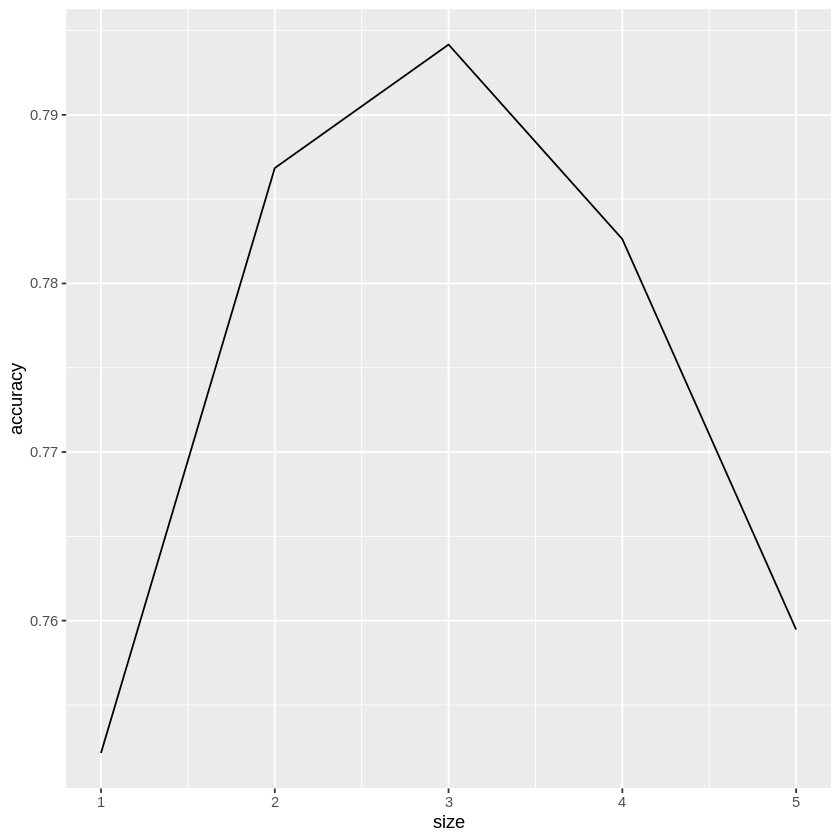

In [25]:
ggplot(accuracies, aes(x=size, y=accuracy)) +
geom_line()

## with predict ##

In [26]:
stroke_split2 <- initial_split(dsampled_stroke, prop = 0.75, strata = stroke)
dsampled_stroke <- training(stroke_split2)
stroke_test2 <- testing(stroke_split2)

In [27]:
stroke_recipe <- recipe(stroke ~ avg_glucose_level + age + hypertension, data = dsampled_stroke) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

In [28]:
stroke_vfold <- vfold_cv(dsampled_stroke, v = 5, strata = stroke)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

In [29]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

In [30]:
knn_results <- workflow() %>%
  add_recipe(stroke_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = stroke_vfold, grid = k_vals) %>%
  collect_metrics() 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.8125541,5,0.03076602,Model03
4,accuracy,binary,0.8125541,5,0.03076602,Model04


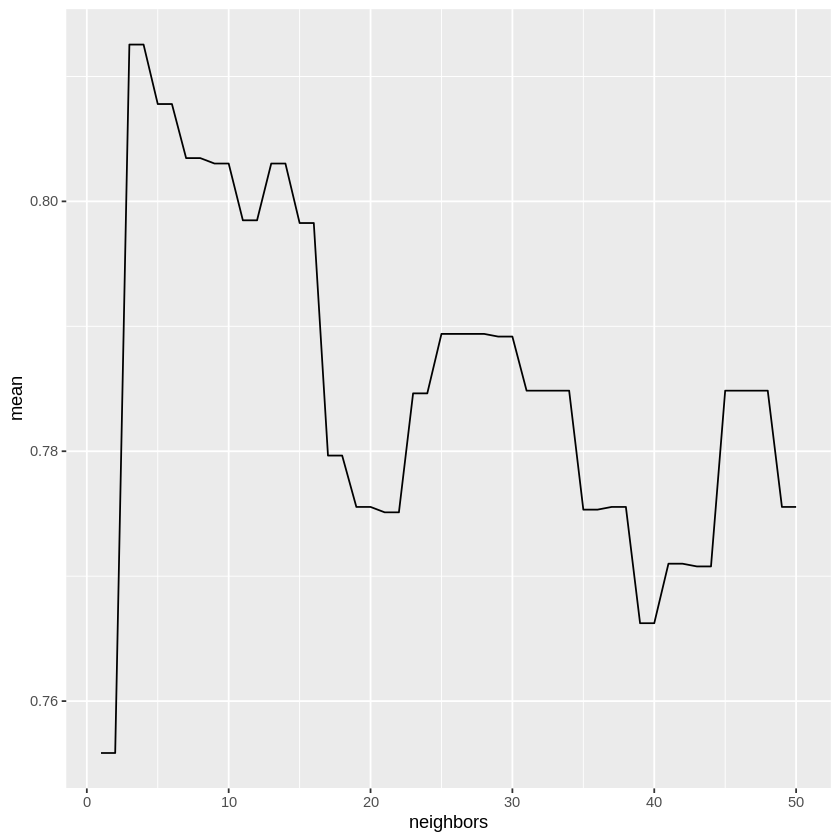

In [31]:
accuracies <- knn_results %>% # Plot accuracies vs neighbours
  filter(.metric == "accuracy")
ggplot(accuracies, aes(x=neighbors, y=mean)) +
    geom_line()
optimal_neighbours <- accuracies %>%
  filter(mean == max(mean))
optimal_neighbours

In [33]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# workflow + fit data
knn_fit <- workflow() %>%
  add_recipe(stroke_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = dsampled_stroke)

stroke_test_predictions <- predict(knn_fit, stroke_test2) %>%
  bind_cols(stroke_test2) %>%
  metrics(truth = stroke, estimate = .pred_class)
stroke_test_predictions
# # calculate rmspe by predicting with credit_testing
# knn_rmspe <- knn_fit %>%
#   predict(credit_testing) %>%
#   bind_cols(credit_testing) %>%
#   metrics(truth = Balance, estimate = .pred) %>%
#   filter(.metric == 'rmse') %>%        
#   select(.estimate) %>%
#   pull()
# knn_rmspe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6571429
kap,binary,0.3142857


stroke_test_predictions %>%
  metrics(truth = stroke, estimate = .pred_class) %>%
  filter(.metric == "accuracy") %>%
  arrange(desc(mass))

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("stroke", "~", paste(preds_new, collapse="+"))
        
        # create a recipe from the model string
        stroke_recipe <- recipe(as.formula(model_string), 
                                data = stroke_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(stroke_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = stroke_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies